In [34]:
import os, sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.append("..")

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import random
import numpy as np
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import time
import pylab as pl
import functools
from IPython import display
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from urllib.request import urlretrieve
import gzip
from PIL import Image
import pathlib
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools
from defconv import  DeformableConv2d

# import monai
# from monai.apps import download_and_extract
# from monai.config import print_config

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm

import gc

# from src import distributions
# import torch.nn.functional as F

# # NOT networks
# from src.resnet2 import ResNet_D
# from src.unet import UNet

# from src.tools import weights_init_D

# # Pix2Pix Networks
# from src.networks import NLayerDiscriminator, UnetGenerator, init_weights, get_norm_layer

# from src.u2net import U2NET
# from src.losses import VGGPerceptualLoss as VGGLoss

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb
# from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [16]:
SEED = 0x000000
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)



T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 77

BATCH_SIZE = 64

PLOT_INTERVAL = 100
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 2000
MAX_STEPS = 100001

In [5]:
class FMRIConnectivityDataset(Dataset):
    def __init__(self, data_directory, ids, transform=None):
        self.transform = transform
        self.data = [] 

        for subject_id in ids:
            rest_file_path = os.path.join(data_directory, f"{subject_id}_rfMRI_REST1_LR.csv")
            motor_file_path = os.path.join(data_directory, f"{subject_id}_tfMRI_MOTOR_LR.csv")

            if os.path.exists(rest_file_path) and os.path.exists(motor_file_path):
                rest_data = pd.read_csv(rest_file_path)
                motor_data = pd.read_csv(motor_file_path)

                self.data.append((subject_id, rest_data.values, motor_data.values))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_id, rest_fMRI_matrix, motor_task_fMRI_matrix = self.data[idx]

        data_dict = {
            "subject_id": subject_id,
            "rest_fMRI_data": torch.FloatTensor(rest_fMRI_matrix[np.newaxis,:,:]),
            "motor_task_fMRI_data": torch.FloatTensor(motor_task_fMRI_matrix[np.newaxis,:,:])
        }

        return data_dict

In [33]:
class Sampler:
    def __init__(
        self, device='cuda',
    ):
        self.device = device
    
    def sample(self, size=5):
        pass

class LoaderSampler(Sampler):
    def __init__(self, loader, device='cuda'):
        super(LoaderSampler, self).__init__(device)
        self.loader = loader
        self.it = iter(self.loader)
        
    def sample(self, size=5):
        assert size <= self.loader.batch_size
        try:
            batch, _ = next(self.it)
        except StopIteration:
            self.it = iter(self.loader)
            return self.sample(size)
        if len(batch) < size:
            return self.sample(size)
            
        return batch[:size].to(self.device)
    from torch.utils.data import DataLoader, random_split

def load_dataset(dataset_class, data_path, img_size, batch_size=32, test_split=0.2, device='cuda'):
    """
    Загружает данные, разделяет их на тренировочную и тестовую выборки, и создает сэмплеры.
    
    Args:
        dataset_class (Dataset): Класс датасета.
        data_path (str): Путь к директории с данными.
        img_size (int): Размер изображения (параметр, если потребуется трансформация).
        batch_size (int): Размер батча.
        test_split (float): Доля данных для тестовой выборки.
        device (str): Устройство для загрузки данных.
    
    Returns:
        Tuple[LoaderSampler, LoaderSampler]: Сэмплеры для тренировочной и тестовой выборок.
    """
    # IDs участников из файлов
    ids = [file.split('_')[0] for file in os.listdir(data_path) if file.endswith('.csv')]
    ids = list(set(ids))  # Убираем дубликаты

    # Создание датасета
    dataset = dataset_class(data_path, ids)

    # Разделение на тренировочную и тестовую выборки
    test_size = int(len(dataset) * test_split)
    train_size = len(dataset) - test_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Создание загрузчиков данных
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Создание сэмплеров
    train_sampler = LoaderSampler(train_loader, device=device)
    test_sampler = LoaderSampler(test_loader, device=device)

    return train_sampler, test_sampler


In [6]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

data_directory = "data_cropp/"

# List all files in the data directory
file_names = [f for f in os.listdir(data_directory) if f.endswith(".csv")]

# Split the file names to extract the subject IDs
file_ids = list(set([file.split('_')[0] for file in file_names]))  

# Define the split ratios (80% train, 20% test)
train_ratio = 0.8
test_ratio = 0.2

# Perform train-test split without intersection
train_ids, remaining_ids = train_test_split(file_ids, test_size=test_ratio, random_state=1380)
test_ids = remaining_ids 

# Create datasets for the training and test sets
train_dataset = FMRIConnectivityDataset(data_directory, train_ids)
test_dataset = FMRIConnectivityDataset(data_directory, test_ids)

# Dataloaders for training and test sets
batch_size = 1
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
train_id_set = set(train_ids)
test_id_set = set(test_ids)
intersection = train_id_set.intersection(test_id_set)
intersection_list = list(intersection)

In [8]:
def freeze(model):
    for p in model.parameters():
        p.requires_grad_(False)
    model.eval()    
    
def unfreeze(model):
    for p in model.parameters():
        p.requires_grad_(True)
    model.train(True)

In [9]:
import random
from itertools import cycle

def sample_fMRI_data(data_loader):
    """
    Sample a batch of fMRI data containing both X (rest) and Y (motor) from a DataLoader.
    
    Args:
        data_loader (DataLoader): The DataLoader for the fMRI dataset.

    Returns:
        tuple of torch.Tensor: A tuple containing X (resting state data) and Y (motor task data).
    """
    if not hasattr(sample_fMRI_data, "data_iterator"):
        # Create an iterator that loops through the data_loader
        sample_fMRI_data.data_iterator = cycle(data_loader)

    batch = next(sample_fMRI_data.data_iterator)
    X = batch["rest_fMRI_data"]
    Y = batch["motor_task_fMRI_data"]

    return X, Y

In [10]:
test_data_rest, test_data_motor = sample_fMRI_data(test_data_loader)
test_data_rest_1, test_data_motor_1 = sample_fMRI_data(test_data_loader)
test_data_rest_2, test_data_motor_2 = sample_fMRI_data(test_data_loader)

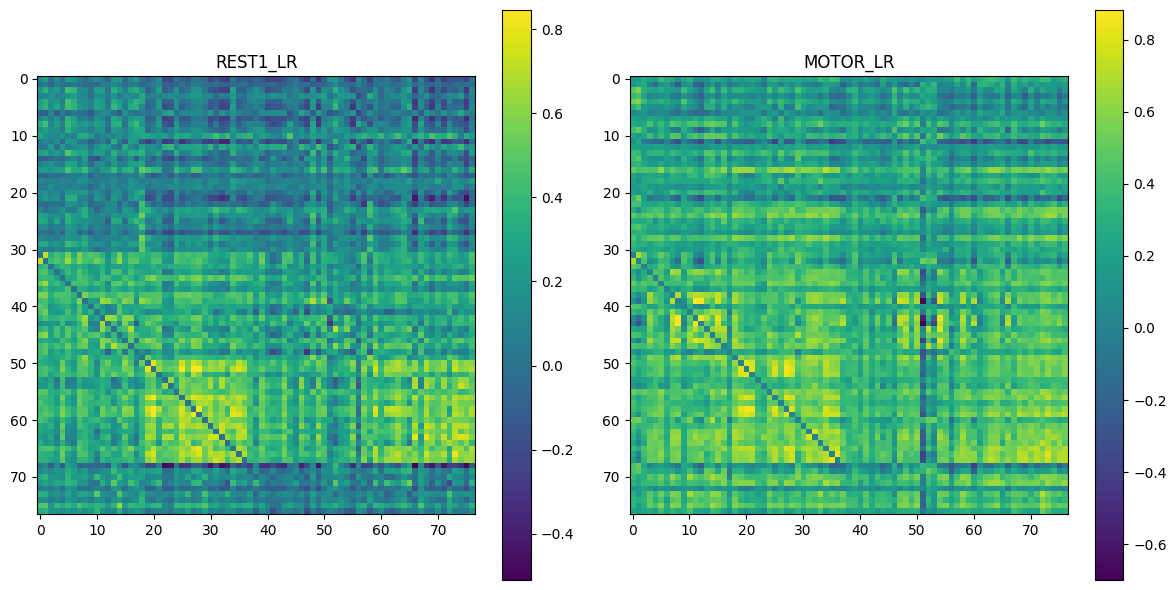

In [11]:
rest_data = np.loadtxt("/beegfs/home/ruslan.kalimullin/data_cropp/118528_rfMRI_REST1_LR.csv", delimiter=",", skiprows=1)
motor_data = np.loadtxt("/beegfs/home/ruslan.kalimullin/data_cropp/118528_tfMRI_MOTOR_LR.csv", delimiter=",", skiprows=1)

plt.figure(figsize=(12, 6)) 

# Heatmap for 580751_rfMRI_REST1_LR.csv
plt.subplot(1, 2, 1)
plt.imshow(rest_data, cmap='viridis', interpolation='nearest')
plt.title("REST1_LR")
plt.colorbar()

# Heatmap for 580751_rfMRI_MOTOR_LR.csv
plt.subplot(1, 2, 2)
plt.imshow(motor_data, cmap='viridis', interpolation='nearest')
plt.title("MOTOR_LR")
plt.colorbar()

plt.tight_layout()  
plt.show()

In [12]:
# Function to plot original and predicted matrices
def plot_original_and_predicted(rest, original, predicted, title_original_rest, title_original_motor, title_predicted):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Original Rest data
    axes[0].set_title(title_original_rest)
    axes[0].imshow(rest[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[0].axis('off')

    # Original Motor data
    axes[1].set_title(title_original_motor)
    axes[1].imshow(original[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[1].axis('off')
    
      # Predicted data
    axes[2].set_title(title_predicted)
    axes[2].imshow(predicted[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[2].axis('off')
    
    plt.show()


# NOT UNet

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools
    
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, base_factor=32, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.base_factor = base_factor

        self.inc = DoubleConv(n_channels, base_factor)
        self.down1 = Down(base_factor, 2 * base_factor)
        self.down2 = Down(2 * base_factor, 4 * base_factor)
        self.down3 = Down(4 * base_factor, 8 * base_factor)
        factor = 2 if bilinear else 1
        self.down4 = Down(8 * base_factor, 16 * base_factor // factor)
        self.up1 = Up(16 * base_factor, 8 * base_factor // factor, bilinear)
        self.up2 = Up(8 * base_factor, 4 * base_factor // factor, bilinear)
        self.up3 = Up(4 * base_factor, 2 * base_factor // factor, bilinear)
        self.up4 = Up(2 * base_factor, base_factor, bilinear)
        self.outc = OutConv(base_factor, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [14]:
import numpy as np
import torch
from torch import nn

class ResNet_G(nn.Module):
    "Generator ResNet architecture from https://github.com/harryliew/WGAN-QC"
    def __init__(self, z_dim, size, nc=3, nfilter=64, nfilter_max=512, bn=True, res_ratio=0.1, **kwargs):
        super().__init__()
        s0 = self.s0 = 4
        nf = self.nf = nfilter
        nf_max = self.nf_max = nfilter_max
        self.bn = bn
        self.z_dim = z_dim
        self.nc = nc

        # Submodules
        nlayers = int(np.log2(size / s0))
        self.nf0 = min(nf_max, nf * 2**(nlayers+1))

        self.fc = nn.Linear(z_dim, self.nf0*s0*s0)
        if self.bn:
            self.bn1d = nn.BatchNorm1d(self.nf0*s0*s0)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

        blocks = []
        for i in range(nlayers, 0, -1):
            nf0 = min(nf * 2**(i+1), nf_max)
            nf1 = min(nf * 2**i, nf_max)
            blocks += [
                ResNetBlock(nf0, nf1, bn=self.bn, res_ratio=res_ratio),
                ResNetBlock(nf1, nf1, bn=self.bn, res_ratio=res_ratio),
                nn.Upsample(scale_factor=2)
            ]

        nf0 = min(nf * 2, nf_max)
        nf1 = min(nf, nf_max)
        blocks += [
            ResNetBlock(nf0, nf1, bn=self.bn, res_ratio=res_ratio),
            ResNetBlock(nf1, nf1, bn=self.bn, res_ratio=res_ratio)
        ]

        self.resnet = nn.Sequential(*blocks)
        self.conv_img = nn.Conv2d(nf, nc, 3, padding=1)

    def forward(self, z):
        batch_size = z.size(0)
        z = z.view(batch_size, -1)
        out = self.fc(z)
        if self.bn:
            out = self.bn1d(out)
        out = self.relu(out)
        out = out.view(batch_size, self.nf0, self.s0, self.s0)

        out = self.resnet(out)

        out = self.conv_img(out)
        out = torch.tanh(out)

        return out


class ResNet_D(nn.Module):
    "Discriminator ResNet architecture from https://github.com/harryliew/WGAN-QC"
    def __init__(self, size=64, nc=3, nfilter=64, nfilter_max=512, res_ratio=0.1):
        super().__init__()
        s0 = self.s0 = 4
        nf = self.nf = nfilter
        nf_max = self.nf_max = nfilter_max
        self.nc = nc

        # Submodules
        nlayers = int(np.log2(size / s0))
        self.nf0 = min(nf_max, nf * 2**nlayers)

        nf0 = min(nf, nf_max)
        nf1 = min(nf * 2, nf_max)
        blocks = [
            ResNetBlock(nf0, nf0, bn=False, res_ratio=res_ratio),
            ResNetBlock(nf0, nf1, bn=False, res_ratio=res_ratio)
        ]

        for i in range(1, nlayers+1):
            nf0 = min(nf * 2**i, nf_max)
            nf1 = min(nf * 2**(i+1), nf_max)
            blocks += [
                nn.AvgPool2d(3, stride=2, padding=1),
                ResNetBlock(nf0, nf0, bn=False, res_ratio=res_ratio),
                ResNetBlock(nf0, nf1, bn=False, res_ratio=res_ratio),
            ]

        self.conv_img = nn.Conv2d(nc, 1*nf, 3, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.resnet = nn.Sequential(*blocks)
        self.fc = nn.Linear(self.nf0*s0*s0, 1)

    def forward(self, x):
        batch_size = x.size(0)

        out = self.relu((self.conv_img(x)))
        out = self.resnet(out)
        out = out.view(batch_size, self.nf0*self.s0*self.s0)
        out = self.fc(out)

        return out


class ResNetBlock(nn.Module):
    def __init__(self, fin, fout, fhidden=None, bn=True, res_ratio=0.1):
        super().__init__()
        # Attributes
        self.bn = bn
        self.is_bias = not bn
        self.learned_shortcut = (fin != fout)
        self.fin = fin
        self.fout = fout
        if fhidden is None:
            self.fhidden = min(fin, fout)
        else:
            self.fhidden = fhidden
        self.res_ratio = res_ratio

        # Submodules
        self.conv_0 = nn.Conv2d(self.fin, self.fhidden, 3, stride=1, padding=1, bias=self.is_bias)
        if self.bn:
            self.bn2d_0 = nn.BatchNorm2d(self.fhidden)
        self.conv_1 = nn.Conv2d(self.fhidden, self.fout, 3, stride=1, padding=1, bias=self.is_bias)
        if self.bn:
            self.bn2d_1 = nn.BatchNorm2d(self.fout)
        if self.learned_shortcut:
            self.conv_s = nn.Conv2d(self.fin, self.fout, 1, stride=1, padding=0, bias=False)
            if self.bn:
                self.bn2d_s = nn.BatchNorm2d(self.fout)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        x_s = self._shortcut(x)
        dx = self.conv_0(x)
        if self.bn:
            dx = self.bn2d_0(dx)
        dx = self.relu(dx)
        dx = self.conv_1(dx)
        if self.bn:
            dx = self.bn2d_1(dx)
        out = self.relu(x_s + self.res_ratio*dx)
        return out

    def _shortcut(self, x):
        if self.learned_shortcut:
            x_s = self.conv_s(x)
            if self.bn:
                x_s = self.bn2d_s(x_s)
        else:
            x_s = x
        return x_s
   

In [18]:
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [21]:
DEVICE_IDS = [0]
f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=48).cuda()

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9715827
f params: 22933441


In [23]:
def plot_images(X, Y, T):
    freeze(T);
    with torch.no_grad():
        T_X = T(X)
        imgs = torch.cat([X, T_X, Y]).to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)

    fig, axes = plt.subplots(3, 10, figsize=(15, 4.5), dpi=150)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        
    axes[0, 0].set_ylabel('X', fontsize=24)
    axes[1, 0].set_ylabel('T(X)', fontsize=24)
    axes[2, 0].set_ylabel('Y', fontsize=24)
    
    fig.tight_layout(pad=0.001)
    torch.cuda.empty_cache(); gc.collect()
    return fig, axes

def plot_random_images(X_sampler, Y_sampler, T):
    X = X_sampler.sample(10)
    Y = Y_sampler.sample(10)
    return plot_images(X, Y, T)

In [27]:
# fig, axes = plot_images(test_data_rest_1, test_data_motor_1, T)
# fig, axes = plot_random_images(test_data_rest_1, test_data_motor_1, T)
# fig, axes = plot_images(test_data_rest_1, test_data_motor_1, T)
# fig, axes = plot_random_images(test_data_rest_1, test_data_motor_1, T)

In [28]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

In [29]:
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        T_X = T(X)
        if COST == 'mse':
            T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
        else:
            raise Exception('Unknown COST')
        T_loss.backward(); T_opt.step()
    del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        T_X = T(X)
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    f_loss = f(T_X).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    wandb.log({f'f_loss' : f_loss.item()}, step=step) 
    del f_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_images(X_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
    
    if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
        freeze(T); 
        
        print('Computing FID')
        mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({f'FID (Test)' : fid}, step=step)
        del mu, sigma
        
        torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
#         torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
#         torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
#         torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))
    
    gc.collect(); torch.cuda.empty_cache()

/tmp/ipykernel_2862831/2287430626.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(MAX_STEPS)):


  0%|          | 0/100001 [00:00<?, ?it/s]

NameError: name 'X_sampler' is not defined